# Section 9

## Assignment

Today you are going to reproduce the example involving the coin tosses taken from the lecture notes.

### Exercise 1 (AST4031 & AST5031):

#### Part I: Toss a coin and estimate the bias for heads

Calculate the posterior PDF for a coin bias for heads ($H$). As in the notes, a "fair" coin has $H = 0.5$, i.e. heads and tails are equally likely. A coin with $H<= 0.5$ is biased to tails; $H>0.5$ is biased to heads; $H = 0$ is a two-tailed coin; $H = 1$ is a two-headed coin.

1. Write a code that simulate N coin tosses, for a coin with $H=0.2$. You will simulate ($N=0, 1, 2, 3, 4, 10, 50, 100, 200, 500$ coin tosses)
2. Write a code that, given the result of the coin tosses, computes the posterior PDF of $H$ over $[0,1]$. Assuming a constant prior for $H$.
3. Compute and show the posteriors for all values of $N$. For $N=1,2,3,4$ specify whether we draw head or tail.
4. What happens as you increase $N$?
5. Change the bias of the coin to 0.5, and repeat (I.2-I.4). Comment on the differences with respect to $H=0.2$

#### Part II: Changing the prior
1. Change the prior to a Gaussian of mean $\mu$ and width $\sigma$? (run $N=100$ tosses)
2. Change the location and width of the prior PDF through the $\mu$, $\sigma$ values. How does the posterior change when you go from a loose prior to a strong one (large $\sigma$ to small $\sigma$)?
3. Given $\mu = 0.5$ and $\sigma = 0.05$, how can you improve the posterior estimate of $H$?
4. How many N do you need to determine bias-weighting to within 0.1 for each prior?
5. Make a plot of $H$ (with error bars) as a function of $N$ (for 30 values of $N$ between 1 and $10^3$). Also plot the value of the true $H$.

### Saving intermediate results
Some computations in this notebook take a long time, so we'll use the `pickle` library to save some intermediate results.

In [1]:
import numpy as np
import scipy.stats as spstats
import matplotlib.pyplot as mplplot
import itertools

import pickle

%matplotlib inline
%load_ext lab_black

In [2]:
regenPosteriors = {
    "GAUSSIAN_MULTI": False,
    "GAUSSIAN": False,
    "UNIFORM": False,
    "BETA": False,
}

##### Part I: Question 1
Each coin toss can be modeled as a Bernoulli trial. Since $0 \leq H \leq 1$ and $H<0.5$ is defined to imply a coin biased towards tails, it makes sense to define a successful trial as one that obtains a _head_ and identify $H$ with the success probability of the trial. In addition to the total number of successes $k$, subsequent parts of the question require us to record the full sequence of coin toss results. Therefore, rather than simply using the PDF for obtaining $k$ successes ($k$ heads) in $N$ trials (i.e. the _Binomial_ distribution: $\mathrm{Bin}(H, N)$), we will simulate several independent _Bernoulli_ trials using the `scipy.stats.bernoulli` function.

In [3]:
def coinTossSequence(numTosses, successProb=0.2):
    return spstats.bernoulli(p=successProb).rvs(numTosses)

In [4]:
coinTossCounts = [1, 2, 3, 4, 10, 50, 100, 200, 500, 1000, 2000, 3000]
successProbs = [0.2, 0.5]
coinTossResults = {
    successProb: {
        numTosses: coinTossSequence(numTosses, successProb)
        for numTosses in coinTossCounts
    }
    for successProb in successProbs
}

Each element of `coinTossResults` is a sequence of zeros (indicating a _tail_) and ones (indicating a _head_). Let's examine the result for 50 coin tosses.

In [5]:
print(
    "Results for 50 coin tosses:",
    "Sequence:",
    coinTossResults[0.2][50],
    "Success fraction:",
    np.sum(coinTossResults[0.2][50]) / coinTossResults[0.2][50].size,
    sep="\n\n",
)

Results for 50 coin tosses:

Sequence:

[1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 0]

Success fraction:

0.16


We see that there are fewer heads than tails, and that the ratio is close to 0.2, as expected. 

##### Note:
For the remainder of the exercise, we will simulate how the posterior evolves as new data are acquired by selecting appropriately sized segments of the longest sequence we generated.

##### Part I: Question 2

To compute the posterior probability distribution function we can use Bayes's rule. Our data are the observed numbers of successes $k$ for each $N$. We've already chosen our Binomial likelihood model $P(k|H)\sim\mathrm{Bin}(H, N)$, and we're told to assume a uniform prior, so we can use the simpler expression from the lecture slides. We can use the **law of total probability** to compute the normalization factor $P(k|N)$. The final expression for the posterior distribution is therefore.
\begin{align}
P(H | k, N) = \frac{P(k|H, N)\mathcal{U}(0,1)}{\displaystyle\sum\limits_{i=0}^{N}{P(i|H, N)P(i)}}
\end{align}

In [6]:
def computeUniformNormalization(numTrials, successProb):
    binomDist = spstats.binom(p=successProb, n=numTrials)
    norm = np.sum(binomDist.pmf(range(numTrials + 1))) / (numTrials + 1)
    return norm


def posteriorForUniformPrior(trialSequence, numTrials, verbose=False):
    trialSubsequence = trialSequence[:numTrials]
    numSuccesses = np.sum(trialSubsequence)
    successProbs = np.linspace(0, 1, 500)
    posterior = [
        spstats.binom(p=successProb, n=numTrials).pmf(numSuccesses)
        / computeUniformNormalization(numTrials, successProb)
        / successProbs.size
        for successProb in successProbs
    ]
    if verbose:
        print(
            "Num trials: {}, Posterior integral = {}".format(
                numTrials, np.sum(posterior)
            )
        )
    return successProbs, posterior, trialSubsequence

##### Part I: Question 3

First, let's compute and store the posterior distributions for different numbers of trials.

In [7]:
if regenPosteriors["UNIFORM"]:
    posteriors = {
        "UNIFORM": {
            successProb: {
                numTosses: posteriorForUniformPrior(
                    ## Use the longest sequence
                    coinTossResults[successProb][coinTossCounts[-1]],
                    numTosses,
                )
                for numTosses in coinTossResults[successProb].keys()
            }
            for successProb in coinTossResults
        }
    }
    pickle.dump(posteriors["UNIFORM"], open("posteriorsUniform.pkl", mode="wb"))
else:
    try:
        posteriors["UNIFORM"] = pickle.load(
            open("posteriorsUniform.pkl", mode="rb")
        )
    except NameError:
        posteriors = {
            "UNIFORM": pickle.load(open("posteriorsUniform.pkl", mode="rb"))
        }

Now we can plot the evolution of the posterior as the number of trials increases.

In [8]:
def plotPosteriorGrid(
    posteriors, coinTossResults, priorKey="UNIFORM", successProb=0.2
):
    figShape = np.array((3, len(coinTossResults[successProb]) // 3))
    posteriorFigure, posteriorPanels = mplplot.subplots(
        figsize=figShape * 4, ncols=figShape[0], nrows=figShape[1]
    )

    for enumerator, (numTosses, posteriorPanel) in enumerate(
        zip(coinTossResults[successProb].keys(), posteriorPanels.flatten())
    ):
        successProbs, posterior, trialSubsequence = posteriors[priorKey][
            successProb
        ][numTosses]
        label = (
            "Last trial: {}\nSequence: {}".format(
                "H" if trialSubsequence[-1] else "T", trialSubsequence
            )
            if enumerator < 4
            else None
        )
        posteriorPanel.plot(successProbs, posterior, label=label)
        posteriorPanel.set_xlabel("H")
        posteriorPanel.set_ylabel("P(H|D)dH")
        posteriorPanel.set_title("N={}".format(numTosses))
        if enumerator < 4:
            posteriorPanel.legend(loc="upper right")
    mplplot.tight_layout()

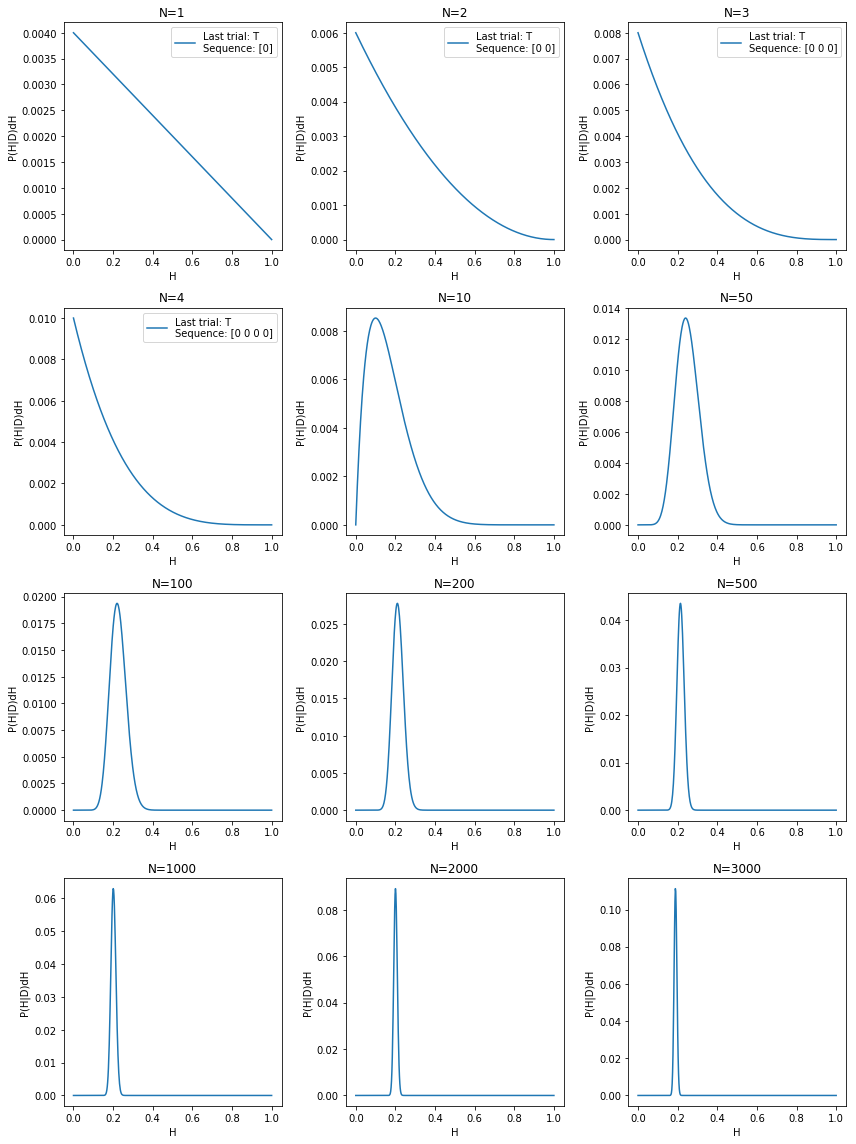

In [9]:
plotPosteriorGrid(posteriors, coinTossResults, "UNIFORM", 0.2)

##### Part I: Question 4

In general, as $N$ increases, the influence of the data in the computation of the likelihood dominates over the uniform prior and the posterior distribution becomes narrower and centres on the true value of $H=0.2$. For $N\lesssim 5$, the random nature of the coin tosses results in noisy behaviour, the data do not provide enough information focus the posterior on the true value of $H$

##### Part I: Question 5

We have already computed everything we need, and defined a handy plotting function, so this is easy!

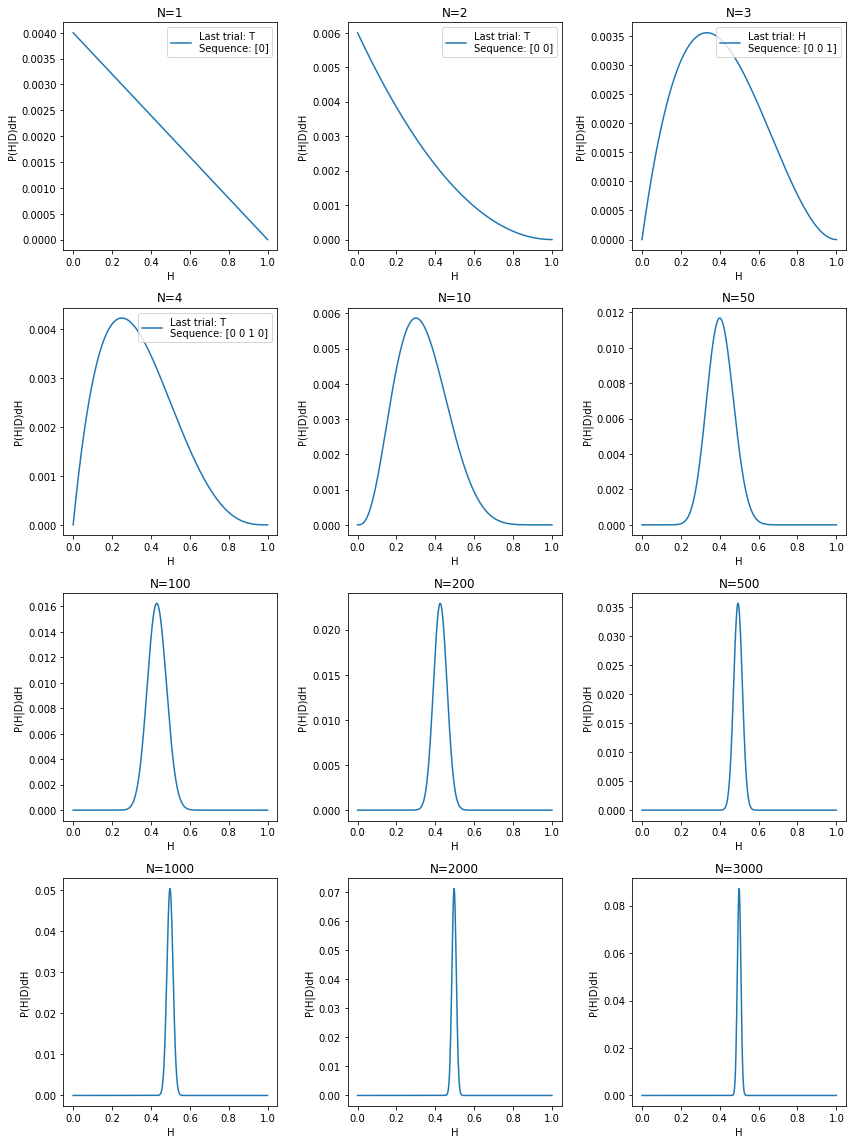

In [10]:
plotPosteriorGrid(posteriors, coinTossResults, "UNIFORM", 0.5)

As before, increasing $N$ increases the influence of the data  over the uniform prior and the prosteriori distribution becomes narrower and centres on the true value of $H=0.5$. However, when the true success probability was 0.2, then the probability of observing $k/N<0.5$ was larger than the probability of observing $k/N>0.5$. This imbalance results in more rapid acquisition of information from successive experiments. For a balanced success probability, extreme values of $H$ are not so rapidly disfavoured.

##### Part II: Question 1
Let's define a new function that computes the posterior for a Gaussian prior.

In [11]:
def gaussianPrior(successProb, mu, sigma):
    return spstats.norm(loc=mu, scale=sigma).pdf(successProb)


def posteriorForGaussianPrior(
    trialSequence, numTrials, mu, sigma, verbose=False
):
    trialSubsequence = trialSequence[:numTrials]
    numSuccesses = np.sum(trialSubsequence)
    successProbs = np.linspace(0, 1, 500)

    posterior = np.array(
        [
            spstats.binom(p=successProb, n=numTrials).pmf(numSuccesses)
            * gaussianPrior(successProb, mu, sigma)
            for successProb in successProbs
        ]
    )
    posterior /= np.sum(posterior)
    posterior *= successProbs.size
    if verbose:
        print(
            "Num trials: {}, Posterior integral = {}".format(
                numTrials, np.sum(posterior)
            )
        )
    return successProbs, posterior, trialSubsequence

##### Part II: Question 2
We can generate and plot the posterior distributions for a variety of Gaussian prior parameters.

In [12]:
priorMeans = np.linspace(0, 1, 9, endpoint=True)
priorSigmas = np.logspace(np.log10(0.05), np.log10(0.5), 5, endpoint=True)

In [13]:
if regenPosteriors["GAUSSIAN"]:
    posteriors["GAUSSIAN"] = {
        (mean, sigma): {
            successProb: {
                numTosses: posteriorForGaussianPrior(
                    ## Use the longest sequence
                    coinTossResults[successProb][coinTossCounts[-1]],
                    numTosses,
                    mean,
                    sigma,
                )
                for numTosses in [100]
            }
            for successProb in coinTossResults
        }
        for mean in priorMeans
        for sigma in priorSigmas
    }
    pickle.dump(
        posteriors["GAUSSIAN"], open("posteriorsGaussian.pkl", mode="wb")
    )
else:
    posteriors["GAUSSIAN"] = pickle.load(
        open("posteriorsGaussian.pkl", mode="rb")
    )

In [14]:
def plotPosteriorGridGaussian(posteriors, priorKey="GAUSSIAN", successProb=0.2):
    priorMeansSigmas = np.array(list(posteriors[priorKey].keys()))
    priorMeans = np.unique(priorMeansSigmas[:, 0])
    priorSigmas = np.unique(priorMeansSigmas[:, 1])

    gaussianPosteriorFigureShape = np.array((3, priorMeans.size // 3))
    gaussianPosteriorFigure, gaussianPosteriorPanels = mplplot.subplots(
        figsize=gaussianPosteriorFigureShape * 4,
        ncols=gaussianPosteriorFigureShape[0],
        nrows=gaussianPosteriorFigureShape[1],
    )

    for enumerator, (meanValue, gaussianPosteriorPanel) in enumerate(
        zip(priorMeans, gaussianPosteriorPanels.flatten())
    ):
        for sigmaValue in priorSigmas:
            successProbs, posterior, trialSubsequence = posteriors[priorKey][
                (meanValue, sigmaValue)
            ][successProb][100]

            gaussianPosteriorPanel.plot(
                successProbs,
                posterior,
                label="$\sigma_{{\pi}}={:.2f}$".format(sigmaValue),
            )

        gaussianPosteriorPanel.set_xlabel("H")
        gaussianPosteriorPanel.set_ylabel("P(H)dH")

        gaussianPosteriorPanel.set_title(
            "$\mu_{{\pi}}={:.2f}$".format(meanValue)
        )
        gaussianPosteriorPanel.legend()

    mplplot.tight_layout()

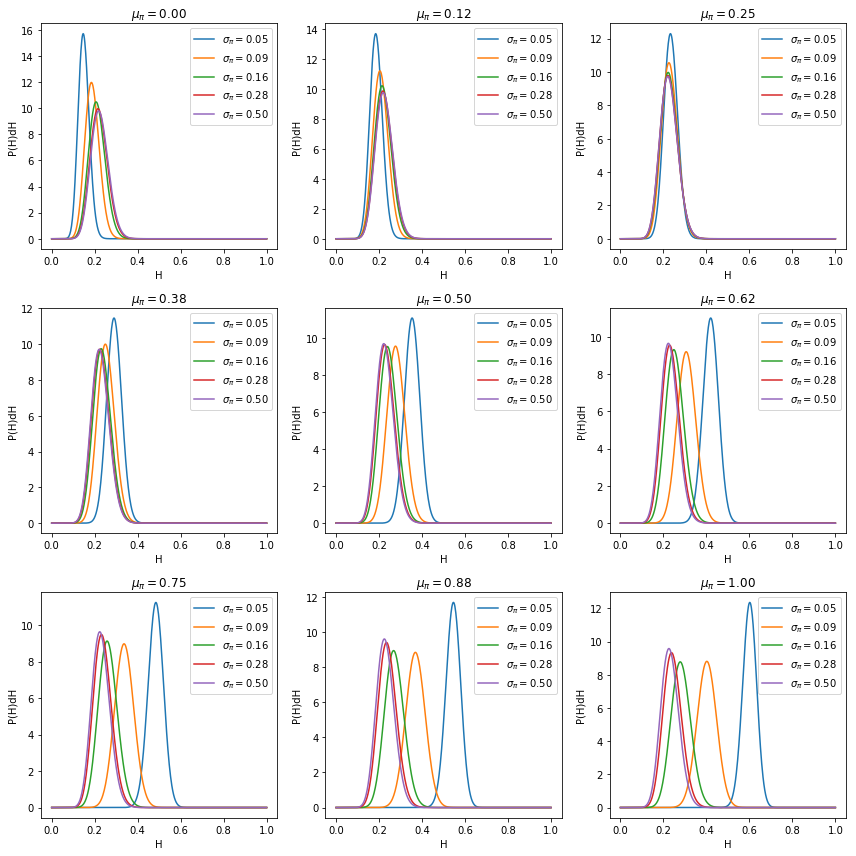

In [15]:
plotPosteriorGridGaussian(posteriors)

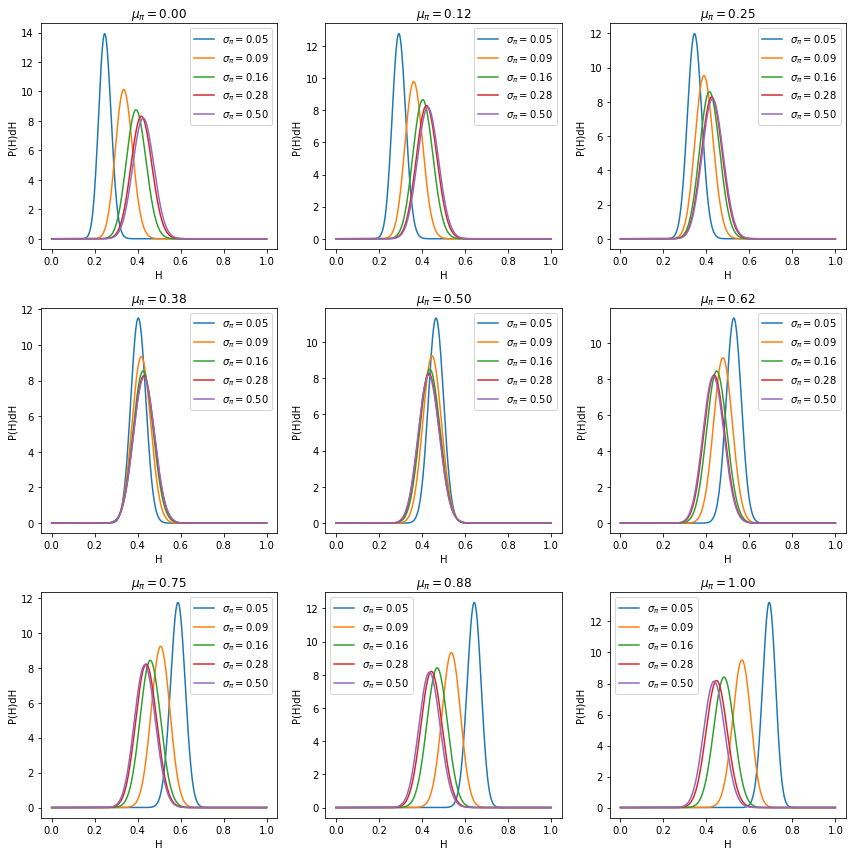

In [16]:
plotPosteriorGridGaussian(posteriors, successProb=0.5)

Narrower prior distributions are more informative. For narrow priors, many more data are required before the information they provide dominates over the prior information. In other words, as $\sigma_{\pi}$ decreases, increasing numbers of data are required for the posterior mean to converge on the true value of $H$.

##### Part II: Question 3
For any particluar values of $\mu_{\pi}$ and $\sigma_{\pi}$, the bias of the posterior distribution can always be reduced by acquiring more data and providing it to the likelhood function.

##### Part II: Question 3/4

In [17]:
if regenPosteriors["GAUSSIAN_MULTI"]:
    posteriors["GAUSSIAN_MULTI"] = {
        (mean, sigma): {
            successProb: {
                numTosses: posteriorForGaussianPrior(
                    ## Use the longest sequence
                    coinTossResults[successProb][coinTossCounts[-1]],
                    numTosses,
                    mean,
                    sigma,
                )
                for numTosses in np.logspace(0, 3, 30).astype(int)
            }
            for successProb in coinTossResults
        }
        for mean in priorMeans
        for sigma in priorSigmas
    }
    pickle.dump(
        posteriors["GAUSSIAN_MULTI"],
        open("posteriorsMultiGaussian.pkl", mode="wb"),
    )
else:
    posteriors["GAUSSIAN_MULTI"] = pickle.load(
        open("posteriorsMultiGaussian.pkl", mode="rb")
    )

For each posterior, we can compute the Maximum _a posterioi_ (MAP) value of $H$ and the Bayesian credible interval containing 68% of the posterior probability density. Since all our posteriors have single peaks, we can compute the credible intervals by sorting the corresponding $H, P(H)$ pairs. Starting from the largest $P(H)$, we find the subset of $H$-values for which the corresponding $P(H)$ values first achieve the desired confidence level. The confidence interval then extends between the extreme $H$ values of the isolated subset.

In [18]:
def findMapAndCredibleInterval(
    successProbs, posteriorPdf, confidenceLevel=0.68
):
    mapValue = successProbs[posteriorPdf.argmax()]

    sortOrder = np.flipud(np.argsort(posteriorPdf))
    sortedPosteriorPdf = posteriorPdf[sortOrder]
    sortedSuccessProbs = successProbs[sortOrder]

    intervalSelection = np.flatnonzero(
        np.cumsum(sortedPosteriorPdf) / np.sum(sortedPosteriorPdf)
        < confidenceLevel
    )

    intervalBounds = np.array(
        [
            sortedSuccessProbs[intervalSelection].min(),
            sortedSuccessProbs[intervalSelection].max(),
        ]
    )
    intervalOffsets = np.array(
        [mapValue - intervalBounds[0], intervalBounds[1] - mapValue]
    )

    return mapValue, intervalOffsets, intervalBounds

In [19]:
hMapsAndIntervals = {
    meanAndSigma: {
        successProb: {
            numTosses: findMapAndCredibleInterval(successProbs, posterior)
            for numTosses, (
                successProbs,
                posterior,
                trialSubsequence,
            ) in ntDict.items()
        }
        for successProb, ntDict in spDict.items()
    }
    for meanAndSigma, spDict in posteriors["GAUSSIAN_MULTI"].items()
}

In [20]:
def plotPosteriorBiasGrid(hMapsAndIntervals, successProb=0.2):
    priorMeansSigmas = np.array(list(hMapsAndIntervals.keys()))
    priorMeans = np.unique(priorMeansSigmas[:, 0])
    priorSigmas = np.unique(priorMeansSigmas[:, 1])

    mapBiasFigureShape = np.array((3, priorMeans.size // 3))
    mapBiasFigure, mapBiasPanels = mplplot.subplots(
        figsize=mapBiasFigureShape * 4,
        ncols=mapBiasFigureShape[0],
        nrows=mapBiasFigureShape[1],
    )

    for enumerator, (meanValue, mapBiasPanel) in enumerate(
        zip(priorMeans, mapBiasPanels.flatten())
    ):
        for sigmaValue in priorSigmas:
            hMapAndIntervalDict = hMapsAndIntervals[(meanValue, sigmaValue)][
                successProb
            ]

            hMapValues = [
                hMapValue for (hMapValue, _, _) in hMapAndIntervalDict.values()
            ]
            intervalOffsetPairs = np.array(
                [
                    intervalOffsetPair
                    for (
                        _,
                        intervalOffsetPair,
                        _,
                    ) in hMapAndIntervalDict.values()
                ]
            ).T

            mapBiasPanel.errorbar(
                hMapAndIntervalDict.keys(),
                hMapValues,
                yerr=intervalOffsetPairs,
                ls="solid",
                label="$\sigma_{{\pi}}={:.2f}$".format(sigmaValue),
            )

        mapBiasPanel.set_xscale("log")
        mapBiasPanel.set_xlabel("N")
        mapBiasPanel.set_ylabel("$H_{\mathrm{MAP}}$")

        mapBiasPanel.axhline(
            y=successProb, c="r", ls="--", label="$H_{\mathrm{true}}$"
        )

        mapBiasPanel.axhline(
            y=successProb + 0.1, c="r", ls="dotted", label=None
        )
        mapBiasPanel.axhline(
            y=successProb - 0.1, c="r", ls="dotted", label=None
        )

        mapBiasPanel.set_title("$\mu_{{\pi}}={:.2f}$".format(meanValue))
        mapBiasPanel.legend()

    mplplot.tight_layout()

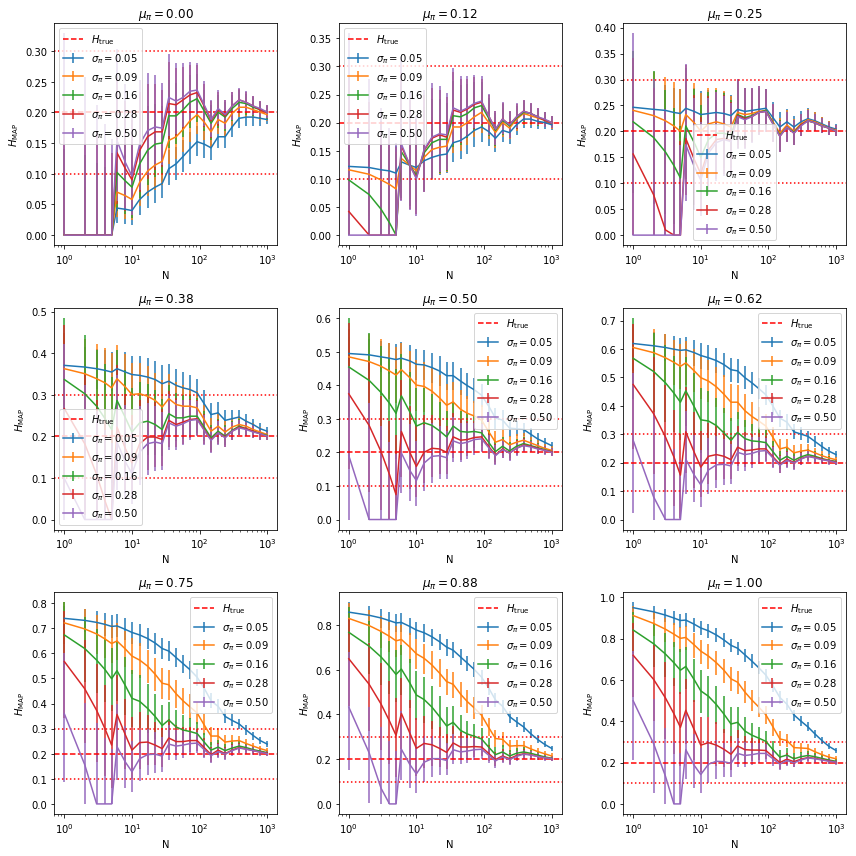

In [21]:
plotPosteriorBiasGrid(hMapsAndIntervals)

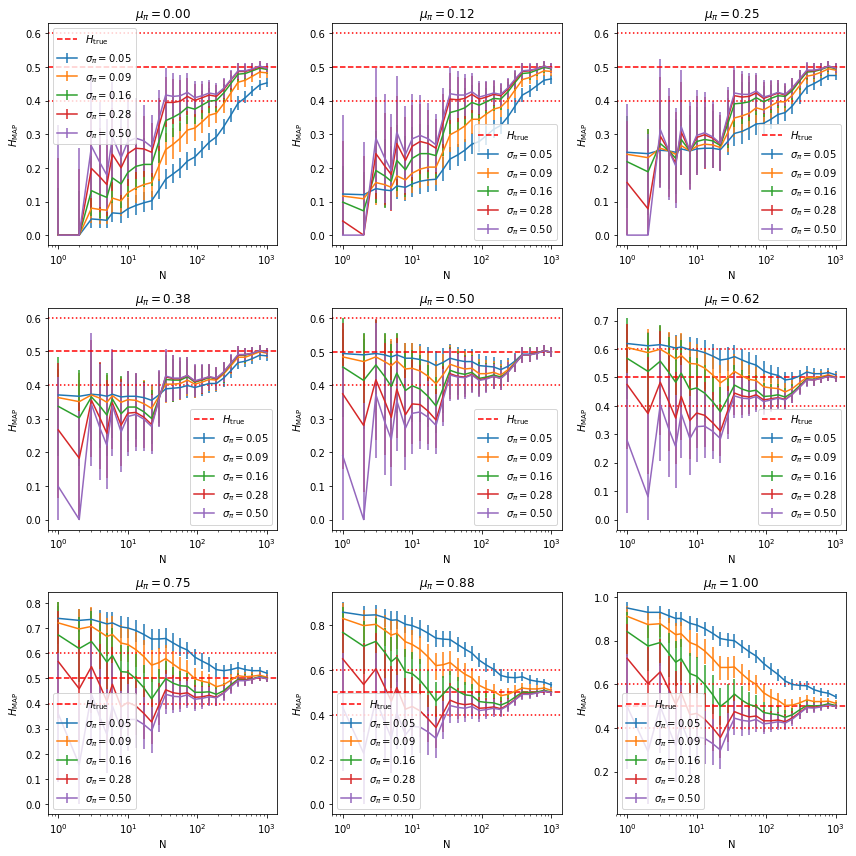

In [22]:
plotPosteriorBiasGrid(hMapsAndIntervals, successProb=0.5)

Depending on the value of information content of the prior and the degree of similarity between the true $H_{\mathrm{true}}$ and the prior mean, different ammounts of experimental data are required for the posterior MAP to converge to $H_{\mathrm{true}}$. In general, more informative priors and priors with means that diverge more from $H_{\mathrm{true}}$ require more data to converge. All tested priors converge to within 0.1 of the $H_{\mathrm{true}}$ for fewer than 1000 coin flips. The maximum number required is ~700 for $H_{\mathrm{true}} = 0.2$, $\mu_{\pi}=1$ and $\sigma_{\pi}=0.05$. 

### Exercise 2 (AST5031):
Consider an extreme prior, that gives more weight to $H=0$ and $H=1$. [Hint: consider the beta distribution].  Repeat I.2 and I.3. How does the posterior change as a function of $N$?

#### Part I: 2
The PDF of _Beta_ distribution has two parameters, $\alpha$ and $\beta$.
\begin{equation}
f(x;\alpha ,\beta )=\frac {1}{\mathrm {B} (\alpha ,\beta )}x^{\alpha -1}(1-x)^{\beta -1}
\end{equation}
where $\mathrm {B} (\alpha ,\beta )$ is the Beta **function** (not the same as the Beta **distribution**!). For small values of $\alpha$ and $\beta$, the probability density of the Beta distribution is concentrated close to 0 and 1.

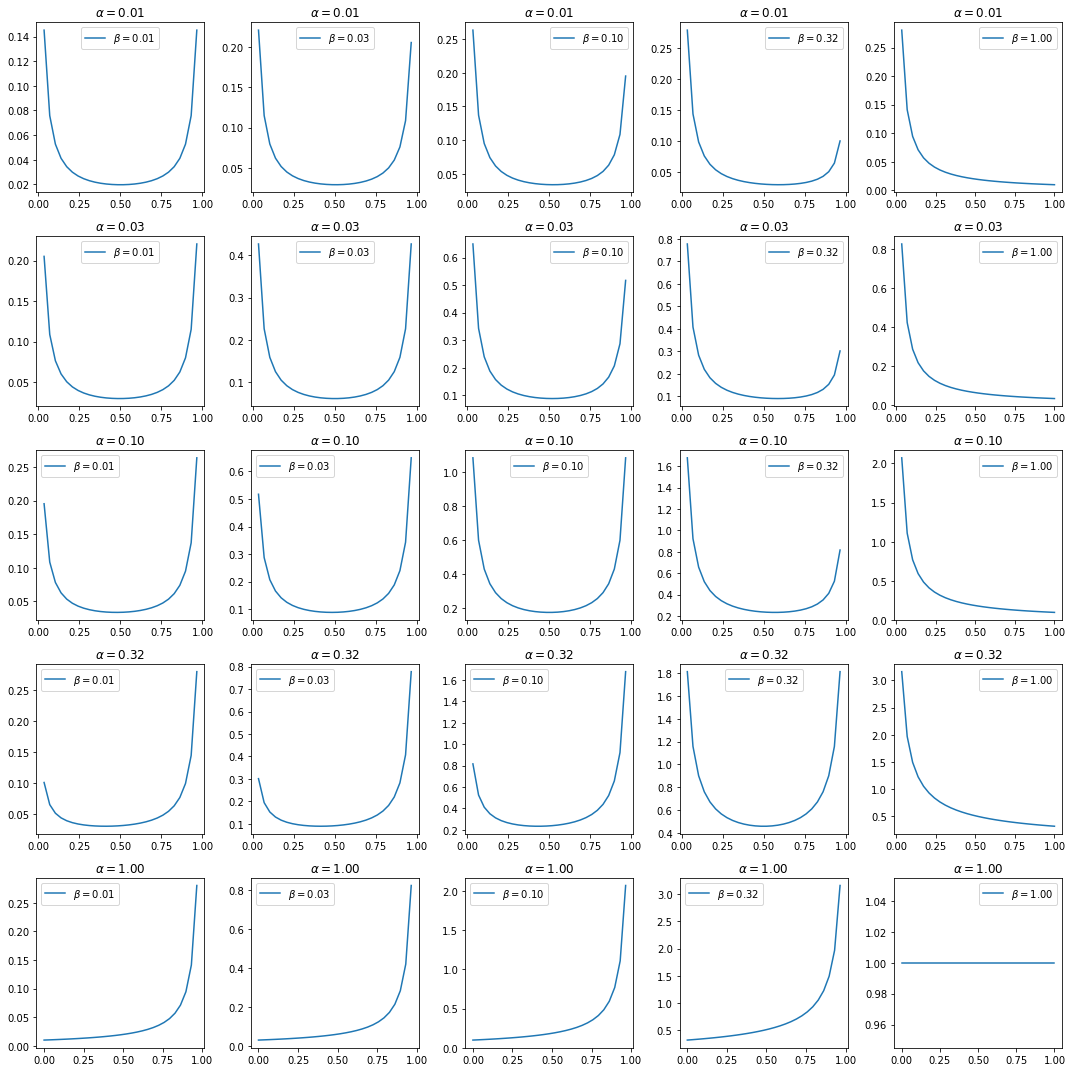

In [23]:
betaParValues = np.logspace(-2, 0, 5)

betaDistFigureShape = np.array((betaParValues.size, betaParValues.size))
betaDistFigure, betaDistPanels = mplplot.subplots(
    figsize=betaDistFigureShape * 3,
    nrows=betaParValues.size,
    ncols=betaParValues.size,
)

for rowCount, alphaVal in enumerate(betaParValues):
    for colCount, betaVal in enumerate(betaParValues):
        betaDistPanel = betaDistPanels[rowCount][colCount]
        betaDistPanel.plot(
            np.linspace(0, 1, 30),
            spstats.beta(alphaVal, betaVal).pdf(np.linspace(0, 1, 30)),
            label=r"$\beta = {:.2f}$".format(betaVal),
        )
        betaDistPanel.set_title(r"$\alpha = {:.2f}$".format(alphaVal))
        betaDistPanel.legend()
mplplot.tight_layout()

A new function to compute the posterior assuming a _Beta_ prior distribution for $H$.

In [24]:
def posteriorForBetaPrior(
    trialSequence, numTrials, betaA, betaB, verbose=False
):
    trialSubsequence = trialSequence[:numTrials]
    numSuccesses = np.sum(trialSubsequence)
    successProbs = np.linspace(0, 1, 500)[1:-1]

    posterior = np.array(
        [
            spstats.binom(p=successProb, n=numTrials).pmf(numSuccesses)
            * spstats.beta(betaA, betaB).pdf(successProb)
            for successProb in successProbs
        ]
    )
    if np.any(np.isnan(posterior)):
        print(
            betaA,
            betaB,
            numTrials,
            *zip(
                [
                    spstats.binom(p=successProb, n=numTrials).pmf(numSuccesses)
                    for successProb in successProbs
                ],
                [
                    spstats.beta(betaA, betaB).pdf(successProb)
                    for successProb in successProbs
                ],
                successProbs,
            ),
            sep="\n",
        )
        raise RuntimeError
    posterior /= np.sum(posterior)
    posterior *= successProbs.size
    if verbose:
        print(
            "Num trials: {}, Posterior integral = {}".format(
                numTrials, np.sum(posterior)
            )
        )
    return successProbs, posterior, trialSubsequence

Compute and store the posterior distributions, given our coin toss data.

In [25]:
if regenPosteriors["BETA"]:
    posteriors["BETA"] = {
        (betaA, betaB): {
            successProb: {
                numTosses: posteriorForBetaPrior(
                    ## Use the longest sequence
                    coinTossResults[successProb][coinTossCounts[-1]],
                    numTosses,
                    betaA,
                    betaB,
                )
                for numTosses in np.logspace(0, 3, 10).astype(int)
            }
            for successProb in coinTossResults
        }
        for betaA in betaParValues
        for betaB in betaParValues
    }
    pickle.dump(posteriors["BETA"], open("posteriorsBeta.pkl", mode="wb"))
else:
    posteriors["BETA"] = pickle.load(open("posteriorsBeta.pkl", mode="rb"))

Generate some plots to examine the dependence of the posterior on the prior parameters.

In [26]:
def plotPosteriorVsParsGridBeta(
    posteriors, priorKey="BETA", successProb=0.2, numTrials=1000
):
    priorAlphasBetas = np.array(list(posteriors[priorKey].keys()))
    priorAlphas = np.unique(priorAlphasBetas[:, 0])
    priorBetas = np.unique(priorAlphasBetas[:, 1])

    betaPosteriorFigureShape = np.array((3, int(np.ceil(priorAlphas.size / 3))))
    betaPosteriorFigure, betaPosteriorPanels = mplplot.subplots(
        figsize=betaPosteriorFigureShape * 4,
        ncols=betaPosteriorFigureShape[0],
        nrows=betaPosteriorFigureShape[1],
    )

    for enumerator, (alphaValue, betaPosteriorPanel) in enumerate(
        itertools.zip_longest(priorAlphas, betaPosteriorPanels.flatten())
    ):
        # Remove axes from unused panels and skip plotting
        if enumerator >= priorAlphas.size:
            betaPosteriorPanel.axis("off")
            continue

        for betaValue in priorBetas:
            successProbs, posterior, trialSubsequence = posteriors[priorKey][
                (alphaValue, betaValue)
            ][successProb][numTrials]

            betaPosteriorPanel.plot(
                successProbs,
                posterior,
                label=r"$\beta_{{\pi}}={:.2f}$".format(betaValue),
            )

        betaPosteriorPanel.axvline(
            x=successProb,
            c="r",
            ls="dotted",
            label=r"$H_{{\mathrm{{true}}}}={}$".format(successProb),
        )

        betaPosteriorPanel.set_xlabel("H")
        betaPosteriorPanel.set_ylabel("P(H)dH")

        betaPosteriorPanel.set_title(
            r"$H_{{\mathrm{{true}}}}={},\;N={},\;\alpha_{{\pi}}={:.2f}$".format(
                successProb, numTrials, alphaValue
            )
        )
        betaPosteriorPanel.legend()

    mplplot.tight_layout()

Plots for **10 coin tosses**.

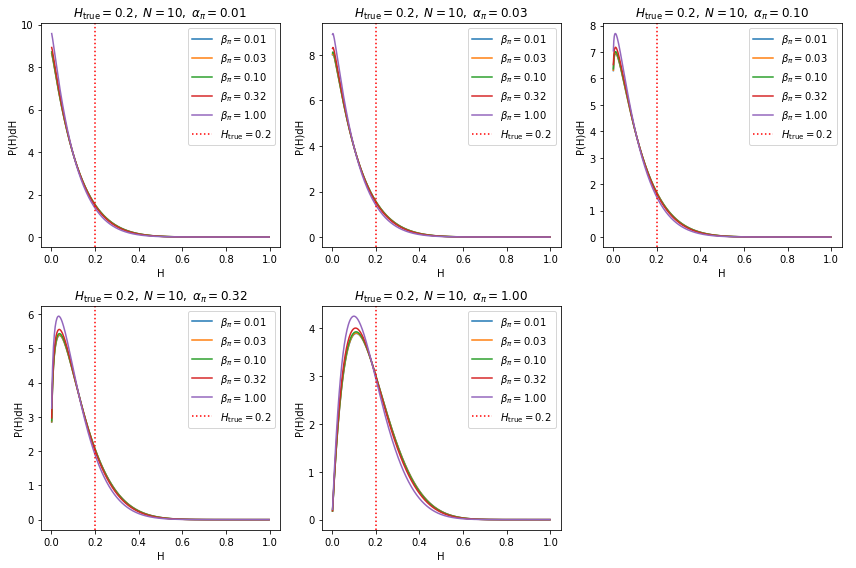

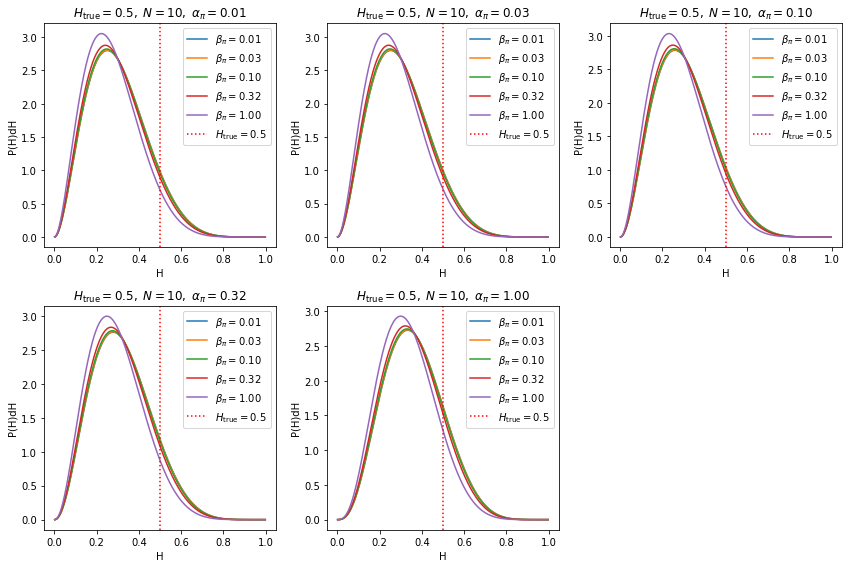

In [27]:
plotPosteriorVsParsGridBeta(posteriors, successProb=0.2, numTrials=10)
plotPosteriorVsParsGridBeta(posteriors, successProb=0.5, numTrials=10)

Plots for **100 coin tosses**.

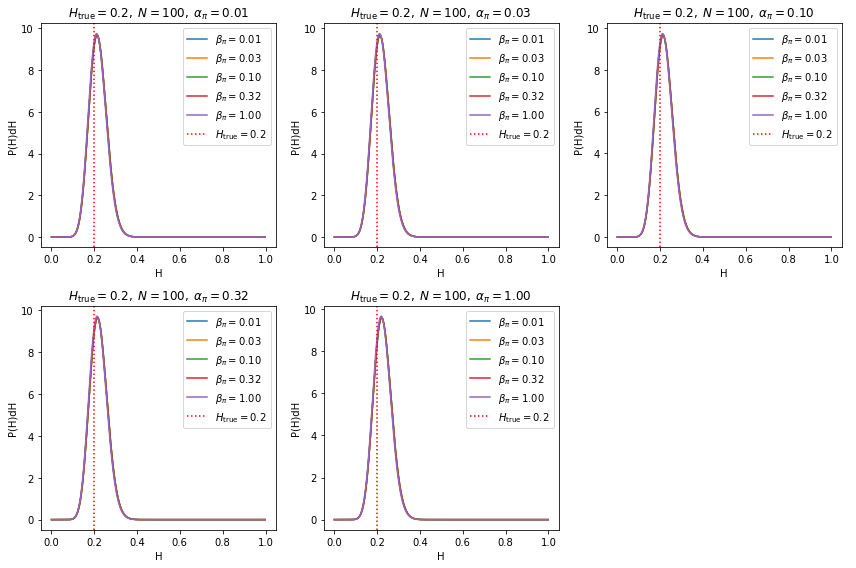

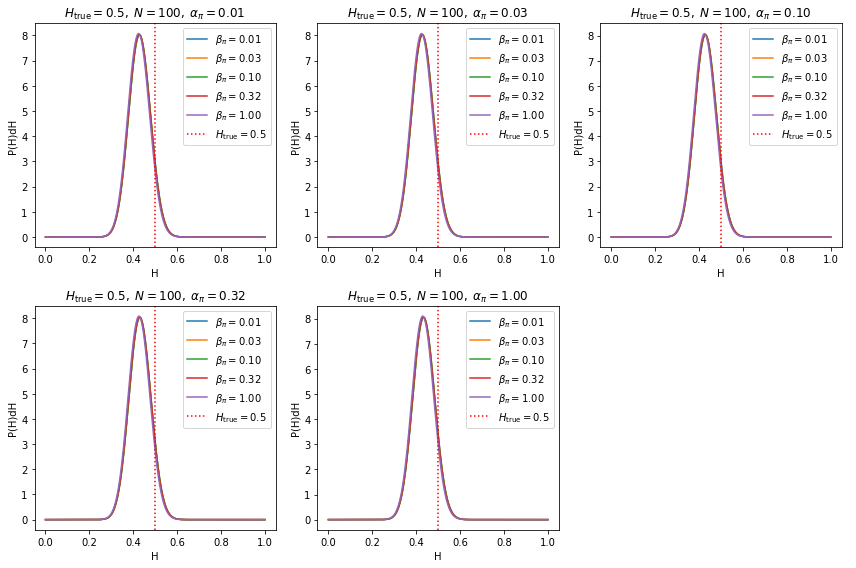

In [28]:
plotPosteriorVsParsGridBeta(posteriors, successProb=0.2, numTrials=100)
plotPosteriorVsParsGridBeta(posteriors, successProb=0.5, numTrials=100)

Plots for **1000 coin tosses**.

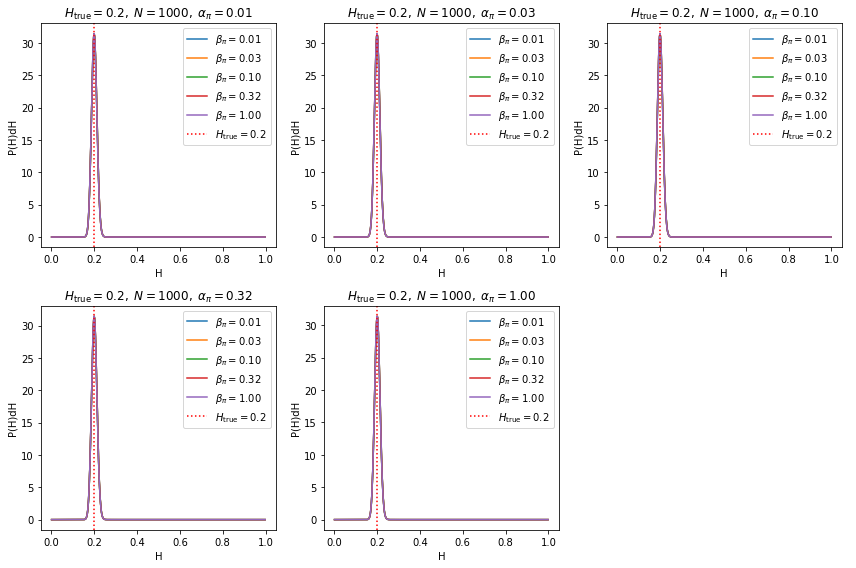

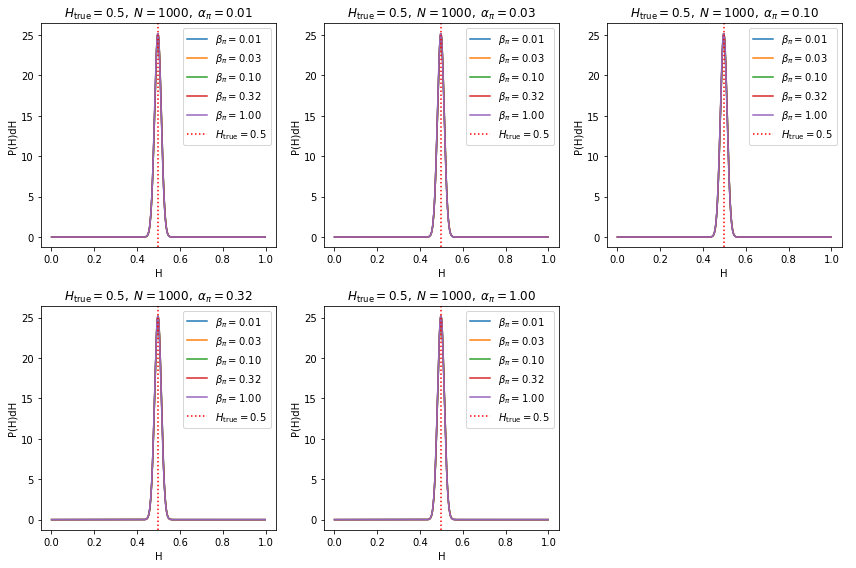

In [29]:
plotPosteriorVsParsGridBeta(posteriors, successProb=0.2, numTrials=1000)
plotPosteriorVsParsGridBeta(posteriors, successProb=0.5, numTrials=1000)

In general we see that with the _Beta_ priors, it takes **many** data before the posterior MAP converges to $H_{\mathrm{true}}$.

We'll generate some plots to examine the dependence of the posterior on the number of coint tosses more directly.

In [30]:
def plotPosteriorVsNGridBeta(
    posteriors, alphaValue, betaValue, priorKey="BETA", successProb=0.2
):
    priorAlphasBetas = np.array(list(posteriors[priorKey].keys()))
    priorAlphas = np.unique(priorAlphasBetas[:, 0])
    priorBetas = np.unique(priorAlphasBetas[:, 1])

    trialCounts = np.fromiter(
        posteriors[priorKey][(alphaValue, betaValue)][successProb].keys(),
        dtype=int,
    )

    betaPosteriorFigureShape = np.array((3, int(np.ceil(trialCounts.size / 3))))
    betaPosteriorFigure, betaPosteriorPanels = mplplot.subplots(
        figsize=betaPosteriorFigureShape * 4,
        ncols=betaPosteriorFigureShape[0],
        nrows=betaPosteriorFigureShape[1],
    )

    for enumerator, (trialCount, betaPosteriorPanel) in enumerate(
        itertools.zip_longest(trialCounts, betaPosteriorPanels.flatten())
    ):

        # Remove axes from unused panels and skip plotting
        if enumerator >= trialCounts.size:
            betaPosteriorPanel.axis("off")
            continue

        successProbs, posterior, trialSubsequence = posteriors[priorKey][
            (alphaValue, betaValue)
        ][successProb][trialCount]

        betaPosteriorPanel.plot(
            successProbs,
            posterior,
            label=r"$\alpha_{{\pi}}={:.2f},\;\beta_{{\pi}}={:.2f}$".format(
                alphaValue, betaValue
            ),
        )

        betaPosteriorPanel.axvline(
            x=successProb,
            c="r",
            ls="dotted",
            label=r"$H_{{\mathrm{{true}}}}={}$".format(successProb),
        )

        betaPosteriorPanel.set_xlabel("H")
        betaPosteriorPanel.set_ylabel("P(H)dH")

        betaPosteriorPanel.set_title(
            r"$H_{{\mathrm{{true}}}}={},\;N={},\;k={}\;{}$".format(
                successProb,
                trialCount,
                np.sum(trialSubsequence),
                " {}".format(trialSubsequence) if trialCount <= 10 else "",
            )
        )
        betaPosteriorPanel.legend(loc="upper right")

    mplplot.tight_layout()

Plots for $\alpha=1$, $\beta=0.1$.

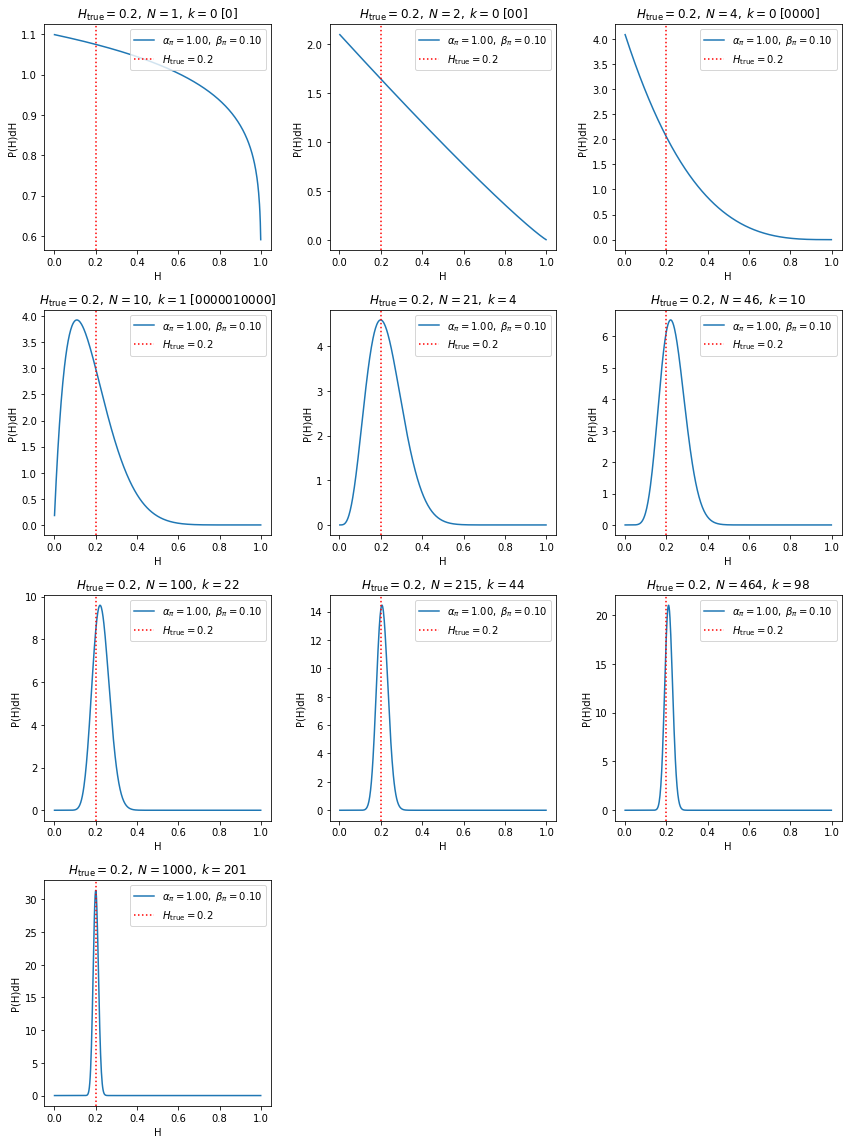

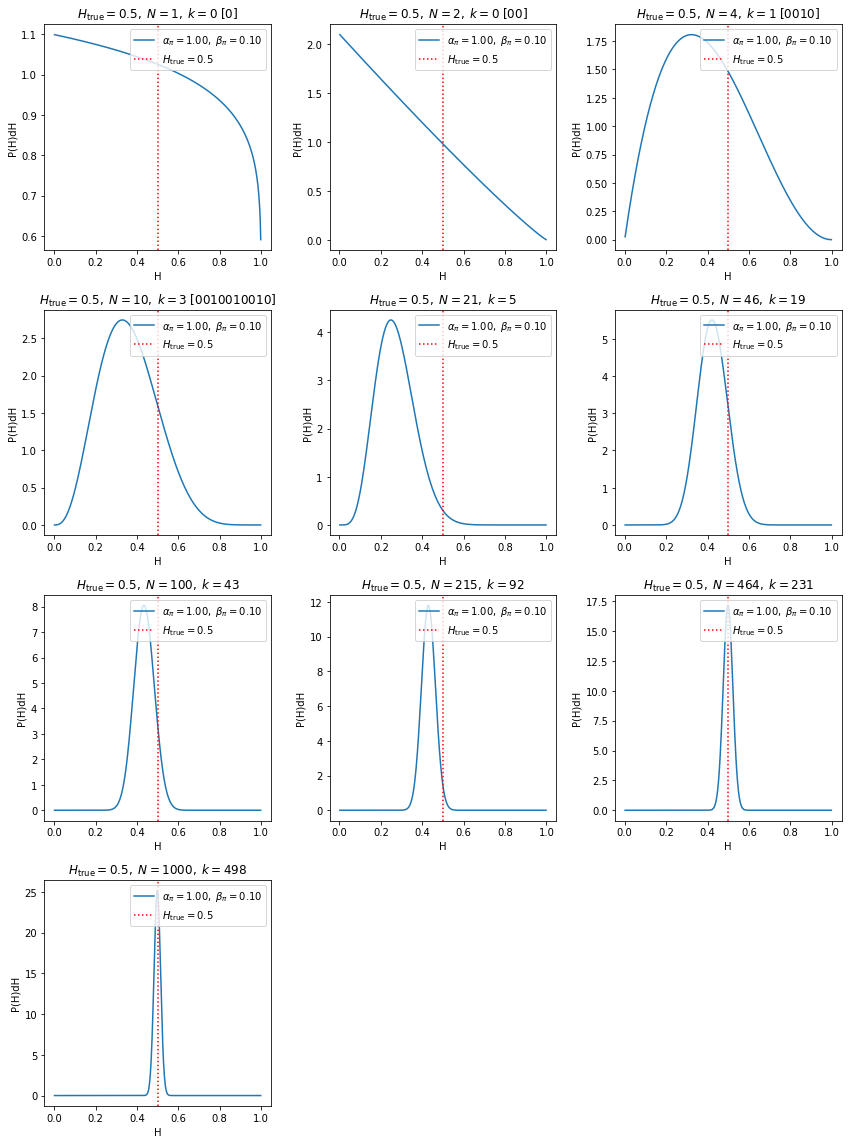

In [31]:
plotPosteriorVsNGridBeta(
    posteriors, alphaValue=1, betaValue=0.1, priorKey="BETA", successProb=0.2
)
plotPosteriorVsNGridBeta(
    posteriors, alphaValue=1, betaValue=0.1, priorKey="BETA", successProb=0.5
)

Plots for $\alpha=0.1$, $\beta=1$.

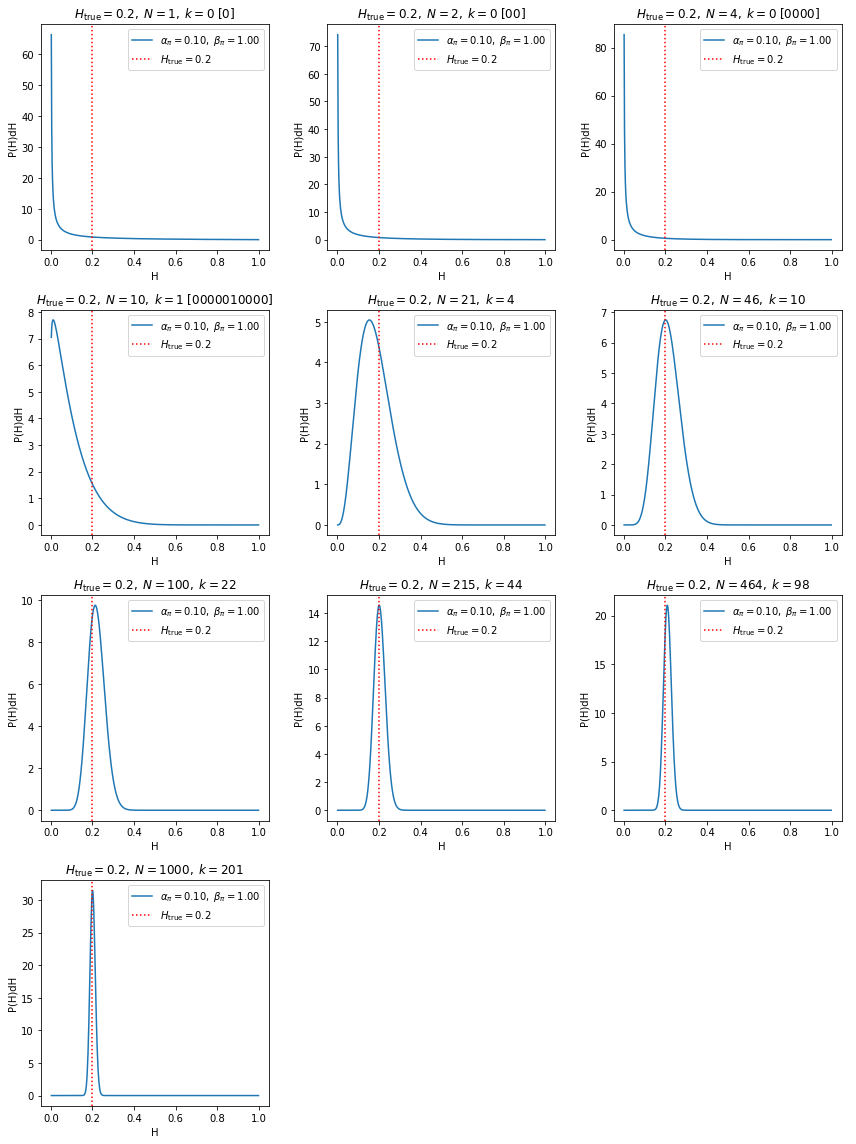

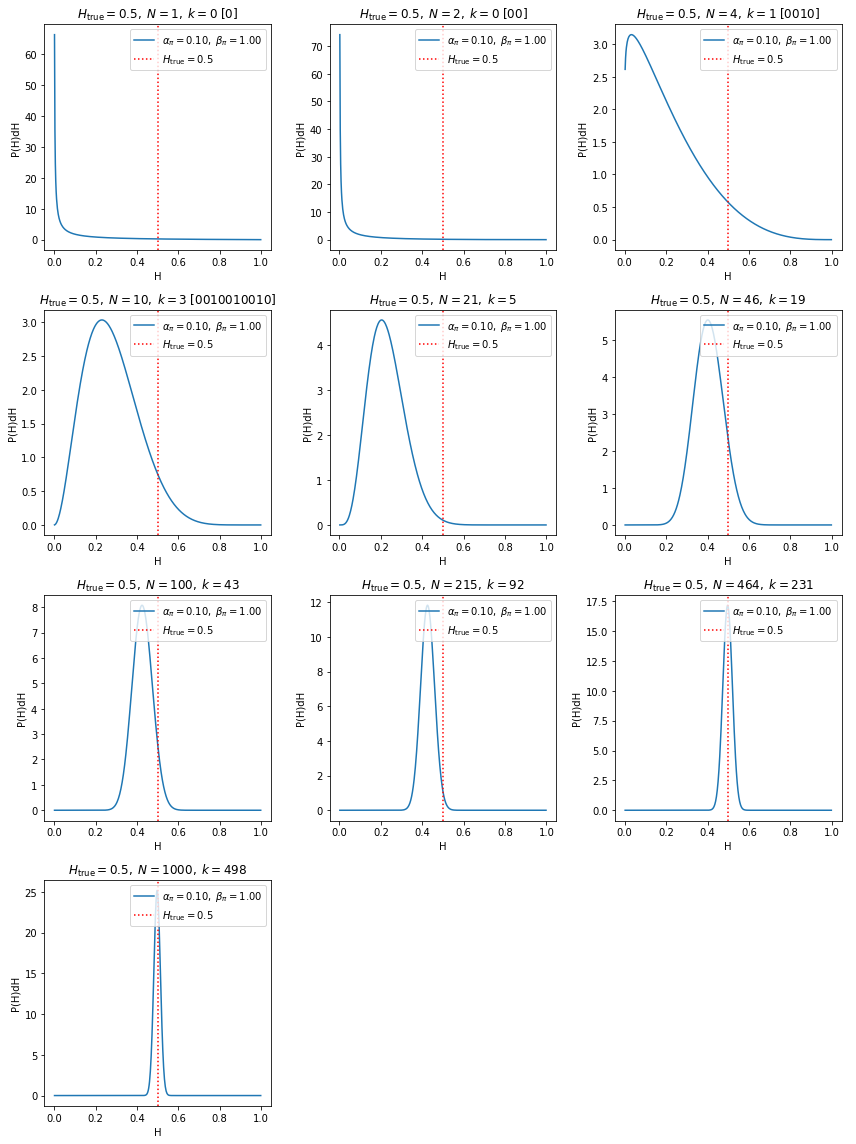

In [32]:
plotPosteriorVsNGridBeta(
    posteriors, alphaValue=0.1, betaValue=1, priorKey="BETA", successProb=0.2
)
plotPosteriorVsNGridBeta(
    posteriors, alphaValue=0.1, betaValue=1, priorKey="BETA", successProb=0.5
)

Plots for $\alpha=0.1$, $\beta=0.1$.

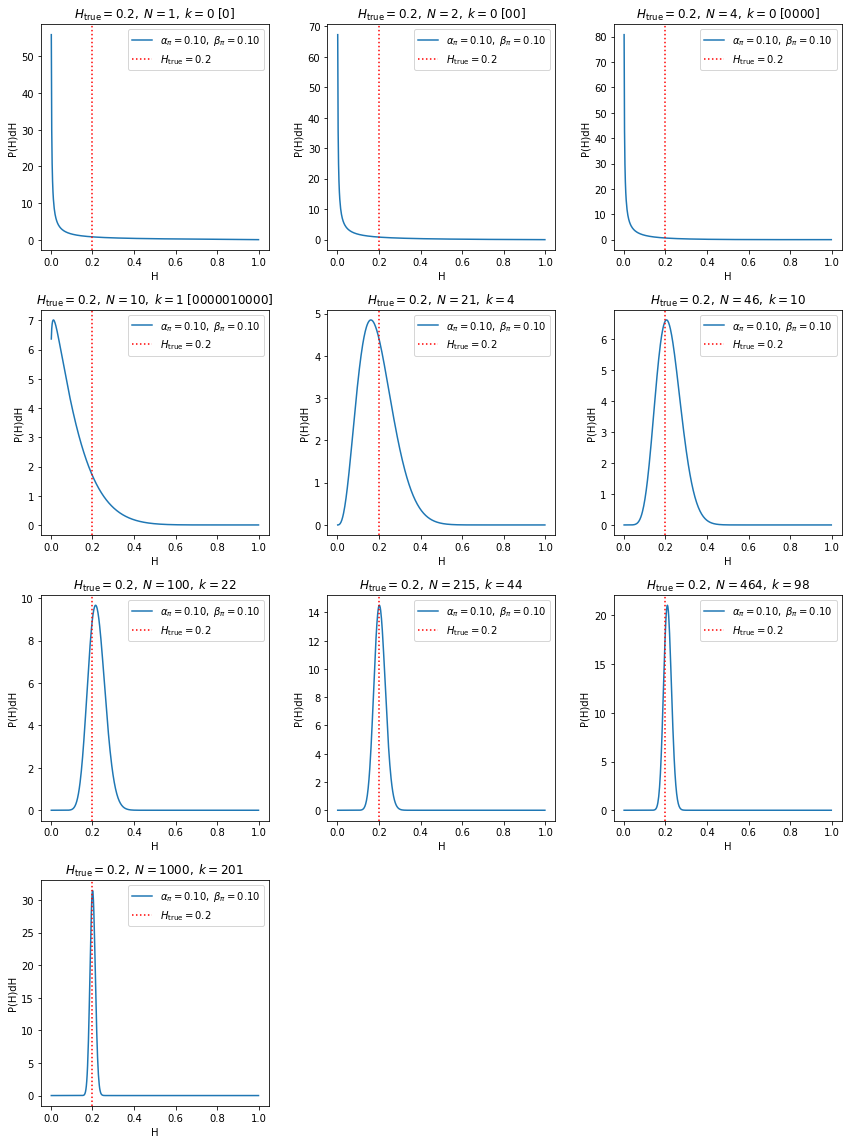

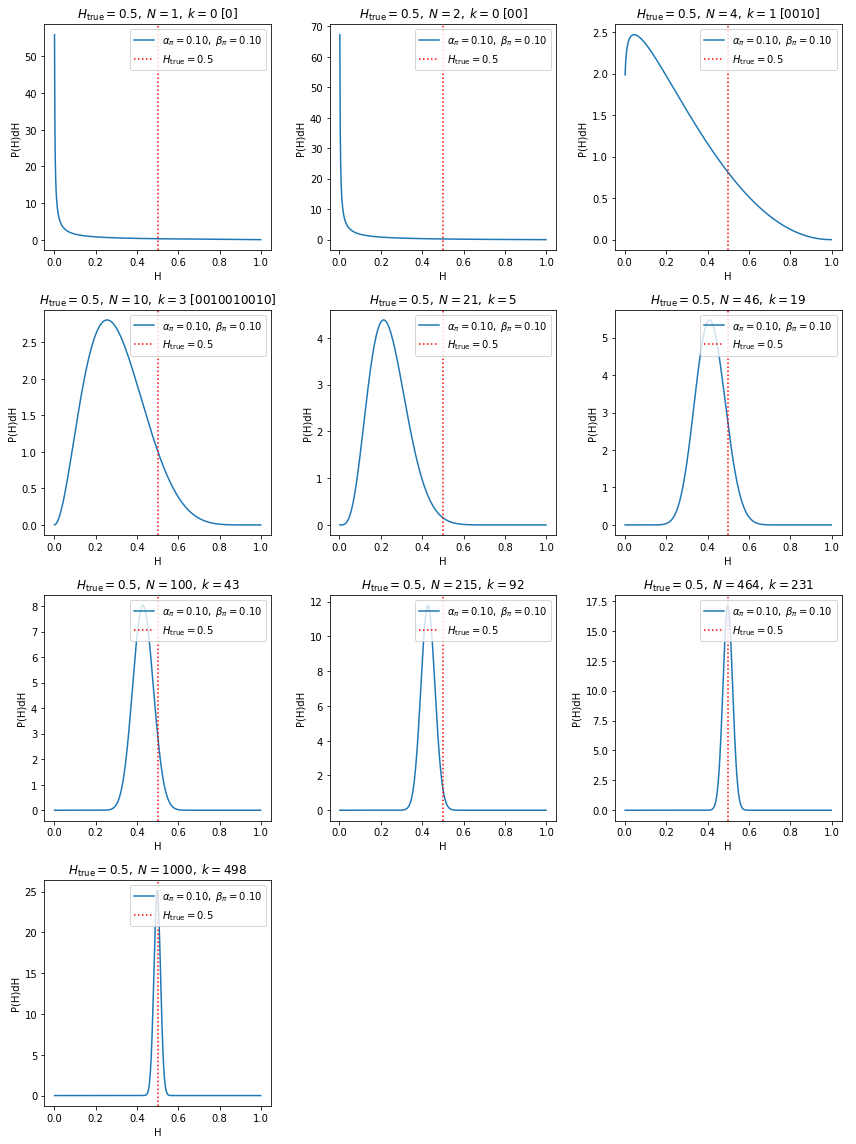

In [33]:
plotPosteriorVsNGridBeta(
    posteriors, alphaValue=0.1, betaValue=0.1, priorKey="BETA", successProb=0.2
)
plotPosteriorVsNGridBeta(
    posteriors, alphaValue=0.1, betaValue=0.1, priorKey="BETA", successProb=0.5
)